### Get data from Steam Community Market API and save to csv

In [6]:
import re
import requests
import pandas as pd

dailyCookie = "76561199704981720%7C%7CeyAidHlwIjogIkpXVCIsICJhbGciOiAiRWREU0EiIH0.eyAiaXNzIjogInI6MTcwQl8yNDkzRTBDMF80QkU4NSIsICJzdWIiOiAiNzY1NjExOTk3MDQ5ODE3MjAiLCAiYXVkIjogWyAid2ViOmNvbW11bml0eSIgXSwgImV4cCI6IDE3MTg2NTU3NjcsICJuYmYiOiAxNzA5OTI4NjU5LCAiaWF0IjogMTcxODU2ODY1OSwgImp0aSI6ICIxNEY5XzI0OTNFMEQxX0VEMDlGIiwgIm9hdCI6IDE3MTgzNjI3ODYsICJydF9leHAiOiAxNzM2NjE4ODA2LCAicGVyIjogMCwgImlwX3N1YmplY3QiOiAiODEuMTA1LjIwMS41NyIsICJpcF9jb25maXJtZXIiOiAiOTAuMTk3Ljc5LjEzMyIgfQ.g6lI2sJQecwdJpnm9I0Ssp-3VrAyH1VhTaEfzMCuHs3hXptMJhyIbwxU7UR95VrUzWaS5qOpfDiCiRMKOdhpAw"
items = ["Glove Case Key", "Officer Jacques Beltram | Gendarmerie Nationale", "Kilowatt Case"]

def fetch_item_to_df(item):
    # get historical price data of item from API
    url = "https://steamcommunity.com/market/pricehistory/"
    params = {
        'country': 'US',
        'currency': '1',
        'appid': '730',
        'market_hash_name': item
    }
    cookies = {'steamLoginSecure': dailyCookie}

    response = requests.get(url, params=params, cookies=cookies)
    jsonData = response.json()

    # print error message if request failed
    if response.status_code != 200:
        print(f"Failed to fetch data for {item}. Status code: {response.status_code}")
        return None

    # convert and clean data to dataframe object
    price_history = jsonData['prices']
    price_history_df = pd.DataFrame(price_history, columns=['date', 'price_usd', 'volume'])
    price_history_df['date'] = pd.to_datetime(price_history_df['date'].str[:-7], format='%b %d %Y')
    price_history_df.set_index('date', inplace=True)
    return price_history_df

def sanitize_filename(filename):
    """Sanitizes the filename to ensure it is valid for most operating systems."""
    filename = re.sub(r'[\\/*?:"<>|]', '_', filename)  # Replace disallowed characters with underscore
    filename = re.sub(r'\s+', '_', filename)  # Replace spaces with underscores
    return filename

def save_item_to_csv(item):
    csvData = './data/'+ sanitize_filename(item) +'.csv'
    fetch_item_to_df(item).to_csv(csvData, index=True)

# fetch and save data in items to csv
for index, item in enumerate(items):
    save_item_to_csv(item)





### Generate graphs for items

In [15]:
# Mann Co. Supply Crate Key
from matplotlib import pyplot as plt

items = ["Glove Case Key", "Officer Jacques Beltram | Gendarmerie Nationale", "Kilowatt Case", "AK-47 | Blue Laminate (Factory New)"]

current_item = fetch_item_to_df(items[3])
# calculate 7-day moving average to smoothen the price trend
# current_item['smoothened_price'] = current_item['price_usd'].rolling(window=7).mean()

print(type(current_item.index))

# print(current_item.head())
# filtered_data = current_item[current_item['date'] > '2023-01-01']

#plt.plot(current_item['date'], current_item['price_usd'], marker='o', label='Original Price')
# plt.plot(current_item['date'], current_item['price_usd'], marker='o', linestyle='--', label='Smoothened Price')
# plt.xlabel('Date')
# plt.ylabel('Price in USD')
# plt.title('Price Trend Over Time')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.legend()
# plt.show()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


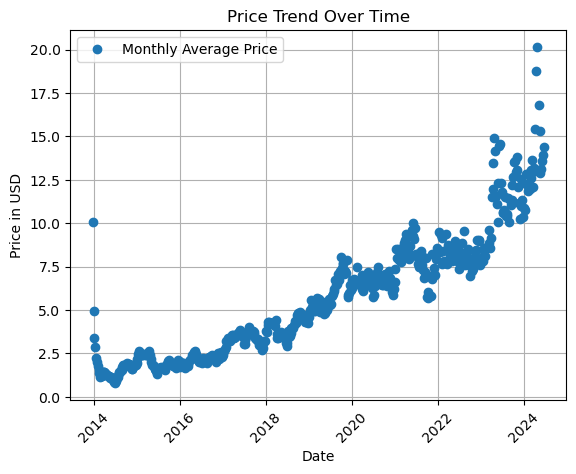

In [ ]:
weekly_averages = current_item['price_usd'].resample('W').mean()

# Reset index to make 'date' a column again for plotting
weekly_averages = weekly_averages.reset_index()
plt.plot(weekly_averages['date'], weekly_averages['price_usd'], marker='x', linestyle='None', label='Weekly Average Price')

plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Price Trend Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()